In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Data loader

In [ ]:
bs = 100 #batch size

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Classifier


In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(32*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
      
           
    def forward(self, x):
                x=self.conv1(x)
                x=F.max_pool2d(x, 2 ,2)
                x = F.relu(x)
                
                x=self.conv2(x)
                x=F.max_pool2d(x, 2 ,2)
                x = F.relu(x)
                x= x.view(-1,32*5*5)
                
                x=self.fc1(x)
                x = F.relu(x)
                
                x=self.fc2(x)
                x = F.relu(x)
                
                x=self.fc3(x)
                
                
                return F.log_softmax(x)

In [ ]:

def train(epoch):
    
    for batch_id, (data, label) in enumerate(train_loader):
        clf.train()
        data=data.cuda()
        label=label.cuda()
        opt.zero_grad()
        preds = clf(data)
        loss = torch.diag(preds[:,label])
        loss =  -torch.mean(loss)
        loss.backward()
        opt.step()
        predind = preds.data.max(1)[1] 
        acc = predind.eq(label.data).cpu().float().mean() 
        
        if batch_id % 100 == 0:
            print("Train Loss: "+str(loss.item())+" Acc: "+str(acc.item()))

            #run independent test
            clf.eval() # set model in inference mode (need this because of dropout)
            test_loss = 0
            correct = 0
        
            for data, target in test_loader: 
                data=data.cuda()
                target=target.cuda()  
                with torch.no_grad():    
                   output = clf(data)
                   test_loss += F.nll_loss(output, target).item()
                   pred = output.data.max(1)[1] 
                   correct += pred.eq(target.data).cpu().sum()

            test_loss = test_loss
            test_loss /= len(test_loader) # loss function already averages over batch size
            accuracy =  correct.item() / len(test_loader.dataset)
            #print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            #    test_loss, correct, len(test_loader.dataset),
            #    accuracy))
            print("Test Loss: "+str(test_loss)+" Acc: "+str(accuracy))


In [ ]:
clf = CNNClassifier()
clf.cuda()
opt = optim.Adam(clf.parameters(), )
for epoch in range(0, 1):
    print("Epoch %d" % epoch)
    train(epoch)

Epoch 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Loss: 2.2913119792938232 Acc: 0.10999999940395355
Test Loss: 2.297574076652527 Acc: 0.0982
Train Loss: 0.1631660759449005 Acc: 0.9700000286102295
Test Loss: 0.20754083619453012 Acc: 0.9358
Train Loss: 0.15744099020957947 Acc: 0.9599999785423279
Test Loss: 0.1146303506474942 Acc: 0.9659
Train Loss: 0.11118308454751968 Acc: 0.9700000286102295
Test Loss: 0.10745079564163461 Acc: 0.9655
Train Loss: 0.10132558643817902 Acc: 0.9700000286102295
Test Loss: 0.07497693533427081 Acc: 0.9755
Train Loss: 0.08775199949741364 Acc: 0.9599999785423279
Test Loss: 0.07027340726577677 Acc: 0.9787


Network definition

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        
        self.LinLayer1= nn.Linear(g_input_dim,256)
        self.LinLayer2= nn.Linear(256,512)
        self.LinLayer3= nn.Linear(512,1024)
        self.LinLayer4= nn.Linear(1024,g_output_dim)
    # forward method
    def forward(self, x):       
        x= F.leaky_relu(self.LinLayer1(x))
        x= F.leaky_relu(self.LinLayer2(x))
        x= F.leaky_relu(self.LinLayer3(x))
        return torch.tanh( self.LinLayer4(x) )
 

In [ ]:

class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()       
        self.LinLayer1= nn.Linear(d_input_dim,1024)
        self.LinLayer2= nn.Linear(1024,512)
        self.LinLayer3= nn.Linear(512,256)
        self.LinLayer4= nn.Linear(256,1)

    # forward method
    def forward(self, x):
        
        x= F.leaky_relu(self.LinLayer1(x))
        x = F.dropout(x, 0.3)
        x= F.leaky_relu(self.LinLayer2(x))
        x = F.dropout(x, 0.3)
        x= F.leaky_relu(self.LinLayer3(x))
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.LinLayer4(x))
        

Training function definition

In [ ]:

def D_train(x):
    ###
    # input parameter x: a batch of input image data
    ###
    #=======================Train the discriminator=======================#
    D.zero_grad()

 
    x_real = x.view(-1, mnist_dim)# transform the input x to the right dimension
    
    D_out_real= D(x_real)
    
    z = Variable( torch.randn(bs,z_dim).to(device)  )# create random input data for the generator
    x_fake = G(z)
    
    D_out_fake= D(x_fake)

    y_real = torch.ones(bs,1).to(device)
    y_fake = torch.zeros(bs,1).to(device)

    D_real_loss = mean(D_out_real)
    D_fake_loss = criterion(D_out_fake, y_fake)
   
    D_loss= D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()


        
    return  D_loss.data.item()
    
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.randn(bs,z_dim).to(device)   # create random input data for the generator
   
    x = G(z)
    D_out = D(x) 
    y_real = torch.ones(bs,1).to(device)
   
    G_loss = criterion(D_out, y_real)
    G_loss.backward()
    G_optimizer.step()
    
    return G_loss.data.item()
    


Set up networks and training parameters

In [ ]:
# build network
z_dim = 100
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.RMSprop(G.parameters(), lr = lr)
D_optimizer = optim.RMSprop(D.parameters(), lr = lr)

# epoch nbr
n_epoch = 20

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Train the network

In [ ]:
for epoch in range(1, 5):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        x=x.to(device)
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
            

[1/20]: loss_d: -1.110, loss_g: -1.034
[2/20]: loss_d: -1.872, loss_g: 1.389
[3/20]: loss_d: -1.283, loss_g: 0.573
[4/20]: loss_d: -1.036, loss_g: 0.256
[5/20]: loss_d: -0.962, loss_g: 0.292
[6/20]: loss_d: -0.922, loss_g: 0.223
[7/20]: loss_d: -0.818, loss_g: -0.165
[8/20]: loss_d: -0.693, loss_g: -0.226
[9/20]: loss_d: -0.589, loss_g: -0.356
[10/20]: loss_d: -0.434, loss_g: -0.692
[11/20]: loss_d: -0.346, loss_g: -0.868
[12/20]: loss_d: -0.287, loss_g: -1.101
[13/20]: loss_d: -0.200, loss_g: -1.223
[14/20]: loss_d: -0.181, loss_g: -1.336
[15/20]: loss_d: -0.170, loss_g: -1.242
[16/20]: loss_d: -0.142, loss_g: -0.943
[17/20]: loss_d: -0.075, loss_g: -0.874
[18/20]: loss_d: -0.065, loss_g: -1.107
[19/20]: loss_d: -0.068, loss_g: -1.273
[20/20]: loss_d: -0.041, loss_g: -0.451


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


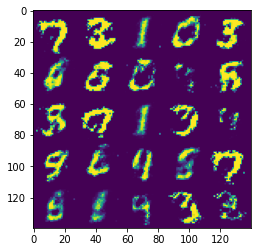

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)
    generated=generated.view(generated.size(0), 1, 28, 28)
    generated=generated.cpu().detach().numpy()
    NumImgs=5
    ImgMatrix=np.zeros((NumImgs*train_dataset.train_data.size(1),NumImgs*train_dataset.train_data.size(2)))
    for i in range(NumImgs):
        for j in range(NumImgs):
            ImgMatrix[i*train_dataset.train_data.size(1):(i+1)*train_dataset.train_data.size(1) ,j*train_dataset.train_data.size(2):(j+1)*train_dataset.train_data.size(2) ]=generated[NumImgs*i+j,0,:,:]
    plt.imshow(ImgMatrix)
    plt.show()
    #plt.savefig('GAN_sample.png')
    #save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')


[138.  96.  95. 208.  66.  57.  60. 142.  49.  89.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


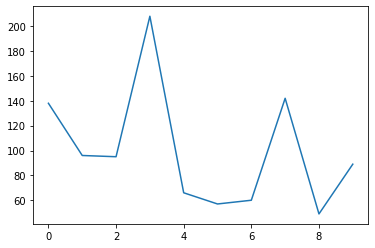

In [ ]:
Classes=np.zeros(10)

with torch.no_grad():
    for i in range(10):
          test_z = Variable(torch.randn(bs, z_dim).to(device))
          generated = G(test_z)
          generated=generated.view(generated.size(0), 1, 28, 28)
          preds=clf(generated)   
          predind = preds.data.max(1)[1] 
          for p in predind.cpu().detach().numpy():
                Classes[p]+=1
print(Classes)
plt.figure()  
plt.plot(Classes)
plt.show()
#plt.savefig('GAN_hist.png')